##### Notebook 2: Model Training

Welcome to Notebook 2 of this recommendation system project!

In Notebook 1, we performed exploratory data analysis (EDA), and visualized various aspects of the data to gain insights into our anime recommendation problem.

In this notebook, we will focus on training the recommendation model. By separating the model training into a separate notebook, we ensure better memory management and organization of the project.

Let's dive in!

Note: If you haven't gone through Notebook 1 yet, I highly recommend you do so to understand the data and insights gained before moving on to the model training phase.

[Click here to access Notebook 1: Exploratory Data Analysis and Dataset Preparation](https://www.kaggle.com/code/dbdmobile/anime-recommendation-1)

In [ ]:
#!pip install wordcloud -q

In [1]:
### Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import warnings
warnings.filterwarnings(action='ignore')

# Data Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# Model Training
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf

## Import necessary modules for collaborative filtering
from keras.layers import Input, Embedding, Dot, Flatten, Dense
from keras.models import Model
from keras.optimizers import Adam
from wordcloud import WordCloud
from collections import defaultdict
from collections import Counter

## Import necessary modules for content-based filtering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

2025-04-02 19:20:49.063934: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the dataset
df=pd.read_csv('dataset/users-score-2023_short.csv', usecols=["user_id","anime_id","rating"])
print("Shape of the Dataset:",df.shape)
df.head()

Shape of the Dataset: (10000, 3)


,user_id,anime_id,rating
0,1,21,9
1,1,48,7
2,1,320,5
3,1,49,8
4,1,304,8


In [3]:
# Checking if there are any duplicate rows
duplicated_rows = df[df.duplicated()]
print("Duplicated Rows:")
print(duplicated_rows)

Duplicated Rows:
Empty DataFrame
Columns: [user_id, anime_id, rating]
Index: []


In [4]:
# Calculating the average score
avg_score = np.mean(df['rating'])
print('Average Score:', avg_score)

Average Score: 7.4825


# Data Preprocessing

In [5]:
# Scaling our "rating" column
# Create a MinMaxScaler object
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the 'score' column between 0 and 1
df['scaled_score'] = scaler.fit_transform(df[['rating']])

In [6]:
# Encoding categorical data

## Encoding user IDs
user_encoder = LabelEncoder()
df["user_encoded"] = user_encoder.fit_transform(df["user_id"])
num_users = len(user_encoder.classes_)

## Encoding anime IDs
anime_encoder = LabelEncoder()
df["anime_encoded"] = anime_encoder.fit_transform(df["anime_id"])
num_animes = len(anime_encoder.classes_)

# Printing dataset information
print("Number of unique users: {}, Number of unique anime: {}".format(num_users, num_animes))
print("Minimum rating: {}, Maximum rating: {}".format(min(df['rating']), max(df['rating'])))

Number of unique users: 74, Number of unique anime: 2603
Minimum rating: 1, Maximum rating: 10


# Model training (collaborative filtering)

In [7]:
# Shuffle the dataset
df = shuffle(df, random_state=100)

# Create feature matrix X and target variable y
X = df[['user_encoded', 'anime_encoded']].values
y = df["scaled_score"].values

# Printing dataset information
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (10000, 2)
Shape of y: (10000,)


In [8]:
test_set_size = int(df.shape[0] * 0.3)  # Number of samples to include in the test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, random_state=73)

print("Number of samples in the training set:", len(y_train))
print("Number of samples in the test set:", len(y_test))

Number of samples in the training set: 7000
Number of samples in the test set: 3000


In [9]:
# Prepare input data for model training and evaluation
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [10]:
# Setting TPU_INIT flag
USE_TPU = False

# Checking if TPU is initialized
if USE_TPU:
    # If tpu is connected then start creating TPUStrategy
    tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu_resolver)
else:
    !nvidia-smi
    
# Print the TensorFlow version
tf_version = tf.__version__
print(f"TensorFlow version: {tf_version}")

/bin/bash: line 1: nvidia-smi: command not found
TensorFlow version: 2.17.0


In [11]:
def RecommenderNet(num_users, num_animes, embedding_size=128):
    # User input layer and embedding layer
    user = Input(name='user_encoded', shape=[1])
    user_embedding = Embedding(name='user_embedding', input_dim=num_users, output_dim=embedding_size)(user)
    
    # Anime input layer and embedding layer
    anime = Input(name='anime_encoded', shape=[1])
    anime_embedding = Embedding(name='anime_embedding', input_dim=num_animes, output_dim=embedding_size)(anime)
    
    # Dot product of user and anime embeddings
    dot_product = Dot(name='dot_product', normalize=True, axes=2)([user_embedding, anime_embedding])
    flattened = Flatten()(dot_product)
    
    # Dense layers for prediction
    dense = Dense(64, activation='relu')(flattened)
    output = Dense(1, activation='sigmoid')(dense)
    
    # Create and compile the model
    model = Model(inputs=[user, anime], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=["mae", "mse"])
    
    return model
# Checking if TPU is initialized and create the model accordingly
if USE_TPU:
    with tpu_strategy.scope():
        model = RecommenderNet(num_users, num_animes)
else:
    model = RecommenderNet(num_users, num_animes)

# Printing my model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_encoded        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_encoded       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │      9,472 │ user_encoded[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │    333,184 │ anime_encoded[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │        128 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         65 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 342,849 (1.31 MB)

 Trainable params: 342,849 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
## Import necessary callbacks
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

# Define the initial learning rate, minimum learning rate, maximum learning rate, and batch size
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
batch_size = 10000

# Adjust the maximum learning rate and batch size if using TPU
if USE_TPU:
    max_lr = max_lr * tpu_strategy.num_replicas_in_sync
    batch_size = batch_size * tpu_strategy.num_replicas_in_sync

# Define the number of epochs for ramp-up, sustain, and exponential decay
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

# Learning rate schedule function
def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr) / rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch - rampup_epochs - sustain_epochs) + min_lr

# Learning rate scheduler callback
lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=0)

# File path for saving the model weights
checkpoint_filepath = 'MLcp/myanime.weights.h5'

# Model checkpoint callback to save the best weights
model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                    save_weights_only=True,
                                    monitor='val_loss',
                                    mode='min',
                                    save_best_only=True)

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(patience=3, monitor='val_loss', mode='min', restore_best_weights=True)

# Define the list of callbacks
my_callbacks = [
    model_checkpoints,
    lr_callback,
    early_stopping
]

In [13]:
# Model training
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data=(X_test_array, y_test),
    callbacks=my_callbacks
)

model.load_weights(checkpoint_filepath)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.6912 - mae: 0.2524 - mse: 0.0835 - val_loss: 0.6913 - val_mae: 0.2493 - val_mse: 0.0822 - learning_rate: 1.0000e-05
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - loss: 0.6912 - mae: 0.2524 - mse: 0.0835 - val_loss: 0.6913 - val_mae: 0.2493 - val_mse: 0.0822 - learning_rate: 1.8000e-05
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - loss: 0.6912 - mae: 0.2524 - mse: 0.0835 - val_loss: 0.6912 - val_mae: 0.2493 - val_mse: 0.0822 - learning_rate: 2.6000e-05
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 0.6911 - mae: 0.2523 - mse: 0.0835 - val_loss: 0.6912 - val_mae: 0.2492 - val_mse: 0.0821 - learning_rate: 3.4000e-05
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step - loss: 0.6911 - mae: 0.2523 - mse: 0.0835 - val_loss: 0.6911 - val_mae: 0.2492 - val_mse: 0.0821 - learning_rate: 4.2000e-05
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - loss: 0.6910 - mae: 0.2522 - mse: 0.0834 - val_loss: 0.6910 - val_mae: 

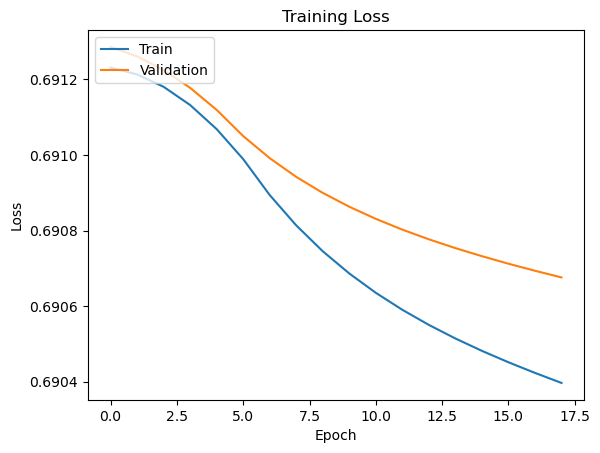

In [14]:
# Training results visualization

plt.plot(history.history["loss"][0:-2])
plt.plot(history.history["val_loss"][0:-2])
plt.title("Training Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

# Model weights extraction

In [15]:
def extract_weights(name, model):
    # Get the layer by name from the model
    weight_layer = model.get_layer(name)
    
    # Get the weights from the layer
    weights = weight_layer.get_weights()[0]
    
    # Normalize the weights
    weights = weights / np.linalg.norm(weights, axis=1).reshape((-1, 1))
    
    return weights

# Extract weights for anime embeddings
anime_weights = extract_weights('anime_embedding', model)
# Extract weights for user embeddings
user_weights = extract_weights('user_embedding', model)

#### Reading the whole dataset

In [16]:
df_anime=pd.read_csv('dataset/full/anime-dataset-2023.csv')

#### Now I want my model to recommend only those animes that have been rated by at least a certain number of users, which I will set as the threshold. This threshold helps ensure that the recommended anime titles have received a sufficient number of ratings, indicating a certain level of popularity or user engagement.

In [ ]:
popularity_threshold = 50
df_anime= df_anime.query('Members >= @popularity_threshold')
print(df_anime.shape)
df_anime.head(3)      # only give rating of those movies for which atleast 200 user have rated

(22879, 24)


,anime_id,Name,English name,Other name,Score,Genres,Synopsis,Type,Episodes,Aired,...,Studios,Source,Duration,Rating,Rank,Popularity,Favorites,Scored By,Members,Image URL
0,1,Cowboy Bebop,Cowboy Bebop,カウボーイビバップ,8.75,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity ...",TV,26.0,"Apr 3, 1998 to Apr 24, 1999",...,Sunrise,Original,24 min per ep,R - 17+ (violence & profanity),41.0,43,78525,914193.0,1771505,https://cdn.myanimelist.net/images/anime/4/196...
1,5,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop: The Movie,カウボーイビバップ 天国の扉,8.38,"Action, Sci-Fi","Another day, another bounty—such is the life o...",Movie,1.0,"Sep 1, 2001",...,Bones,Original,1 hr 55 min,R - 17+ (violence & profanity),189.0,602,1448,206248.0,360978,https://cdn.myanimelist.net/images/anime/1439/...
2,6,Trigun,Trigun,トライガン,8.22,"Action, Adventure, Sci-Fi","Vash the Stampede is the man with a $$60,000,0...",TV,26.0,"Apr 1, 1998 to Sep 30, 1998",...,Madhouse,Manga,24 min per ep,PG-13 - Teens 13 or older,328.0,246,15035,356739.0,727252,https://cdn.myanimelist.net/images/anime/7/203...


# User-based Recommendation

## 1. Finding Similar Users

In this part, we randomly select a user from the dataset and find similar users based on their anime preferences. The find_similar_users function calculates the similarity between users using a weighted matrix and returns a dataframe of similar users. The function takes an input user, number of similar users to find (n), and other optional parameters. The result is a list of similar users to the input user.

In [23]:
def find_similar_users(item_input, n=10, return_dist=False, neg=False):
    try:
        index = item_input
        encoded_index = user_encoder.transform([index])[0]
        weights = user_weights
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)
        n = n + 1
        
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
            
        SimilarityArr = []
        
        for close in closest:
            similarity = dists[close]
            if isinstance(item_input, int):
                decoded_id = user_encoder.inverse_transform([close])[0]
                SimilarityArr.append({"similar_users": decoded_id, "similarity": similarity})
        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        return Frame
    except:
        print('\033[1m{}\033[0m, Not Found in User list'.format(item_input))

In [ ]:
# Select a random user
ratings_per_user = df.groupby('user_id').size()
#input_user = int(ratings_per_user[ratings_per_user < 500].sample(1, random_state=None).index[0])
input_user = 

# Find similar users to the random user
similar_users = find_similar_users(input_user, n=10, neg=False)
similar_users = similar_users[similar_users.similar_users != input_user]
similar_users

,similar_users,similarity
9,232,0.261034
8,229,0.155008
7,67,0.140384
6,300,0.122876
5,293,0.116365
4,242,0.105496
3,208,0.101988
2,110,0.095650
1,169,0.081522
0,71,0.076638


## 2. User Preferences

This part focuses on understanding the preferences of the selected user. The get_user_preferences function takes a user ID as input and retrieves the anime preferences of that user. It considers the top-rated animes by the user and analyzes the genres they prefer. The function also provides an option to plot a word cloud to visualize the preferred genres. The output is a dataframe containing the anime titles and their associated genres.

In [25]:
# Function to display a word cloud of preferred genres
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700, height=400, background_color='white', colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10, 8))
    plt.imshow(genres_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

def get_user_preferences(user_id, plot=False, verbose=0):
    animes_watched_by_user = df[df['user_id'] == user_id]
    
    if animes_watched_by_user.empty:
        print("User #{} has not watched any animes.".format(user_id))
        return pd.DataFrame()
    
    user_rating_percentile = np.percentile(animes_watched_by_user.rating, 75)
    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]
    top_animes_user = (
        animes_watched_by_user.sort_values(by="rating", ascending=False)
        .anime_id.values
    )
    
    anime_df_rows = df_anime[df_anime["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["Name", "Genres"]]
    
    if verbose != 0:
        print("User \033[1m{}\033[0m has watched {} anime(s) with an average rating of {:.1f}/10\n".format(
            user_id, len(animes_watched_by_user), animes_watched_by_user['rating'].mean()
        ))
        print('\033[1m----- Preferred genres----- \033[0m\n')

    if plot:
        genres_list = []
        for genres in anime_df_rows['Genres']:
            if isinstance(genres, str):
                for genre in genres.split(','):
                    genres_list.append(genre.strip())

        showWordCloud(dict(Counter(genres_list)))
    
    return anime_df_rows

User 111 has watched 23 anime(s) with an average rating of 9.4/10

----- Preferred genres----- 



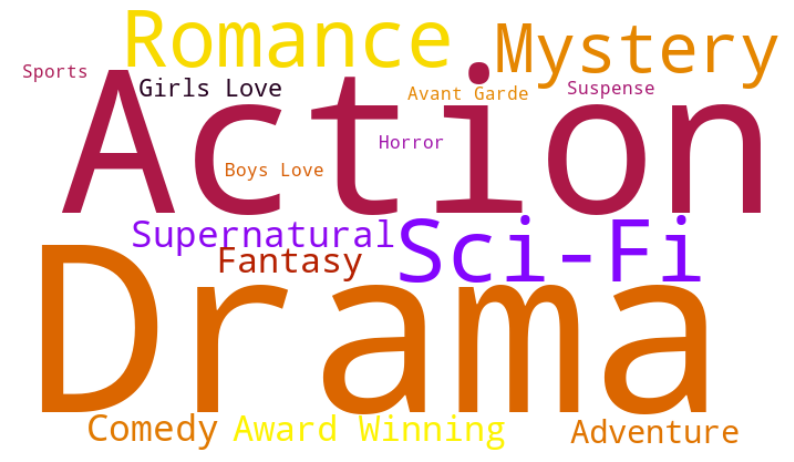

,Name,Genres
3,Witch Hunter Robin,"Action, Drama, Mystery, Supernatural"
6,Hachimitsu to Clover,"Comedy, Drama, Romance"
20,Neon Genesis Evangelion,"Action, Avant Garde, Award Winning, Drama, Sci-Fi, Suspense"
29,.hack//Sign,"Adventure, Fantasy, Mystery"
35,Appleseed (Movie),"Action, Drama, Sci-Fi"


In [ ]:
# Get user preferences for the random user
user_pref = get_user_preferences(input_user, plot=True, verbose=1)
pd.DataFrame(user_pref).head(5)

## 3. Recommending Animes for a User

In the final part, we recommend animes to the selected user based on the preferences of similar users. The get_recommended_animes function iterates through the list of similar users, retrieves their preferences, and identifies animes that are not present in the preferences of the selected user. It then generates a list of recommended animes along with their genres and a brief synopsis. The output is a dataframe containing the recommended animes for the user.

In [27]:
def get_recommended_animes(similar_users, user_pref, n=10):
    recommended_animes = []
    anime_list = []
    
    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id))
        if not pref_list.empty:  # Check if user has watched any animes
            pref_list = pref_list[~pref_list["Name"].isin(user_pref["Name"].values)]
            anime_list.append(pref_list.Name.values)
            
    if len(anime_list) == 0:
        print("No anime recommendations available for the given users.")
        return pd.DataFrame()
    
    anime_list = pd.DataFrame(anime_list)
    sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)
    # Count the occurrences of each anime in the entire dataset
    anime_count = df['anime_id'].value_counts()
    
    for i, anime_name in enumerate(sorted_list.index):
        if isinstance(anime_name, str):
            try:
                anime_id = df_anime[df_anime.Name == anime_name].anime_id.values[0]
                english_name = df_anime[df_anime['Name'] == anime_name]['English name'].values[0]
                name = english_name if english_name != "UNKNOWN" else anime_name
                genre = df_anime[df_anime.Name == anime_name].Genres.values[0]
                Synopsis = df_anime[df_anime.Name == anime_name].Synopsis.values[0]
                n_user_pref = anime_count.get(anime_id, 0)  # Get the total count of users who have watched this anime
                recommended_animes.append({
                    "n": n_user_pref,
                    "anime_name": anime_name, 
                    "Genres": genre, 
                    "Synopsis": Synopsis
                })
            except:
                pass
    return pd.DataFrame(recommended_animes)

In [ ]:
# Get recommended animes for the random user
recommended_animes = get_recommended_animes(similar_users, user_pref, n=10)

print('\n> Top recommendations for user: {}'.format(input_user))
recommended_animes


> Top recommendations for user: 111


,n,anime_name,Genres,Synopsis
0,34,Azumanga Daiou The Animation,"Comedy, Slice of Life","Chiyo Mihama begins her high school career as one of the strangest students in her freshman class—a tiny, 10-year-old academic prodigy with a fondness for plush dolls and homemade cooking. But her homeroom teacher, Yukari Tanizaki, is the kind of person who would hijack a student's bike to avoid being late, so ""strange"" is a relative word.\n\nThere certainly isn't a shortage of peculiar girls in Yukari-sensei's homeroom class. Accompanying Chiyo are students like Tomo Takino, an energetic tomboy with more enthusiasm than brains; Koyomi Mizuhara, Tomo's best friend whose temper has a fuse shorter than Chiyo; and Sakaki, a tall, athletic beauty whose intimidating looks hide a gentle personality and a painful obsession with cats. In addition, transfer student Ayumu Kasuga, a girl with her head stuck in the clouds, fits right in with the rest of the girls—and she has a few interesting theories about Chiyo's pigtails!\n\nTogether, this lovable group of girls experience the ups and downs of school life, their many adventures filled with constant laughter, surreal absurdity, and occasionally even touching commentary on the bittersweet, temporal nature of high school."
1,27,Howl no Ugoku Shiro,"Adventure, Award Winning, Drama, Fantasy, Romance","That jumbled piece of architecture, that cacophony of hissing steam and creaking joints, with smoke billowing from it as it moves on its own... That castle is home to the magnificent wizard Howl, infamous for both his magical prowess and for being a womanizer—or so the rumor goes in Sophie Hatter's small town. Sophie, as the plain daughter of a hatmaker, does not expect much from her future and is content with working hard in the shop. \n\nHowever, Sophie's simple life takes a turn for the exciting when she is ensnared in a disturbing situation, and the mysterious wizard appears to rescue her. Unfortunately, this encounter, brief as it may be, spurs the vain and vengeful Witch of the Waste—in a fit of jealousy caused by a past discord with Howl—to put a curse on the maiden, turning her into an old woman.\n\nIn an endeavor to return to normal, Sophie must accompany Howl and a myriad of eccentric companions—ranging from a powerful fire demon to a hopping scarecrow—in his living castle, on a dangerous adventure as a raging war tears their kingdom apart."
2,46,Naruto,"Action, Adventure, Fantasy","Moments prior to Naruto Uzumaki's birth, a huge demon known as the Kyuubi, the Nine-Tailed Fox, attacked Konohagakure, the Hidden Leaf Village, and wreaked havoc. In order to put an end to the Kyuubi's rampage, the leader of the village, the Fourth Hokage, sacrificed his life and sealed the monstrous beast inside the newborn Naruto.\n\nNow, Naruto is a hyperactive and knuckle-headed ninja still living in Konohagakure. Shunned because of the Kyuubi inside him, Naruto struggles to find his place in the village, while his burning desire to become the Hokage of Konohagakure leads him not only to some great new friends, but also some deadly foes."
3,16,Shaman King,"Action, Adventure, Comedy, Supernatural","A battle is about to begin in Tokyo: the Shaman Fight, a tournament held every five hundred years where shaman—those who can command spirits—confront each other in combat. The victor of this contest becomes the Shaman King and the only one who is able to contact and control the Great Spirit, allowing them to reshape the world as they please through its immense power.\n\nDuring a late night walk, Manta Oyamada runs into his classmate, the carefree You Asakura, who invites him to come stargazing with some friends, who, to Manta's horror, turn out to be ghosts from a local cemetery! However, the knowledge that Manta possesses—a rare sixth sense that allows Manta to see these spirits—endears the boy to You. So when You finds out that his new comrade has been beaten up by a local gang, he decides to avenge him with the help